In [111]:
# Attempt to improve the DMFT code

import numpy as np
import matplotlib.pyplot as plt

In [112]:
########################################################################
# INPUTS
########################################################################

#D0, u0, nloop, xmix, max_omega, T, tol  = np.loadtxt('input.bin')
D0, u0, nloop, xmix, n_omega, beta, tol  = 1.0, 0.5, 500, 0.5, 2000, 100, 1e-6

try:

    data1 = np.loadtxt('.\\DOS.txt')
    energies = data1[:,0]
    DOS   = data1[:,1]

except:

    energies = np.linspace(-D0, D0, 1000)
    DOS = 2*np.sqrt(1-(energies/D0)**2)/(np.pi * D0)

In [113]:
########################################################################
# DMFT ROUTINES
########################################################################

# Computation of the local Green's function

def Dyson_Green (S_imp, Energies, dos, Momega):

    """
    From the self-energy in Matsubara axis, computes the local Green's
    function of the system, as an integral over energies.

    Input:
        S_imp: The current impurity self-energy in Matsubara axis
        Energies: The energy grid used to obtain the local Green's function
        dos: The input DOS of the system, evaluated in Energies
        Momega: Matsubara frequencies grid


    Output:
        G_loc: Local Green's function in Matsubara axis

    """
    
    N_freqs = len(Momega)
    epsrep = Energies.reshape((1,-1)).repeat(N_freqs,0)
    desrep = dos.reshape((1,-1)).repeat(N_freqs,0)
    
    if len(epsrep) == len(desrep):
        
        N_e = epsrep.shape[1]
        N_states = desrep.sum()
        summand = 1.0j*Momega.reshape((-1,1)).repeat(N_e,1) - epsrep - S_imp.reshape((-1,1)).repeat(N_e,1)
        G_loc = np.sum(desrep/summand, axis=1)/(N_states)

        return G_loc
    
def Gloc_omega(S_imp, energies, dos, Momega):
    from scipy.integrate import simpson
    #we use same resultion of energies as for matsubara frequencies
    denergies_bethe = energies[2] - energies[1]
    return simpson( dos/(1j*Momega[:,np.newaxis]-energies-S_imp[:,np.newaxis]), dx=denergies_bethe)

In [114]:
# Fast inverse Fourier transform

def matsubara_ifft(G_omega, beta, tau, Momega):

    """
    Fast inverse Fourier transform. Computes the function in imaginary 
    time axis. It's assumed that both time and frequency axis have the
    same length.

    Input:
        G_omega: Function in Matsubara axis
        beta: Inverse temperature of the system
        tau: Imaginary time grid
        Momega: Matsubara frequencies grid


    Output:
        G_loc: Local Green's function in Matsubara axis

    """

    
    N = len(Momega)
    freq = np.pi/beta*( np.array(-2*N*np.fft.fftfreq(N),dtype=float) +1.)
    k = np.arange(N,dtype='float')
    ifft = -1./2 + N/beta * np.exp(-1.0j*np.pi*k/N) * np.fft.ifft(G_omega - 1./(1.0j*freq))
    
    return ifft

In [115]:
# IPT solver; computes the new self-energy

def Self_Energy_fromG (g0, U, tau, Momega):

    """
    IPT solver to obtain the new self-energy in Matsubara axis from the
    Weiss mean field in imaginary time axis.

    Input:
        g0: Weiss mean field in imaginary time axis
        U: Hubbard interaction parameter
        tau: Imaginary time grid
        Momega: Matsubara frequencies grid


    Output:
        new_S_imp: Updated self-energy in the Matsubara axis

    """

    dtau = tau[1] - tau[0]
    esp = np.exp(1.0j*np.tensordot(tau, Momega, 0))
    g0_minus = -np.roll(g0[::-1],1)
    g0_minus[0] = -g0_minus[0]
    integrand = g0*g0*g0_minus
    new_S_imp = -U*U*dtau*np.matmul(integrand,esp)
    
    return new_S_imp

In [ ]:
# Main DMFT loop: first iteration and subsequent iterations

def DMFT_first_iteration(u0, S_imp, Energies, dos, Momega, tau, beta):

    """
    First iteration of the DMFT loop. Returns the updated self-energy,  
    as well as the non-interacting Green's function and the impurity 
    Green's function.

    Input:
        u0: The Hubbard interaction parameter
        S_imp: The current impurity self-energy in Matsubara axis
        Energies: The energy grid used to obtain the local Green's function
        dos: The input DOS of the system, evaluated in Energies
        Momega: Matsubara frequencies grid
        tau: Imaginary time grid
        beta: Inverse temperature of the system


    Output:
        G_loc: Local Green's function in Matsubara axis
        g_0: Weiss mean field in Matsubara axis
        g_0_tau: Weiss mean field in imaginary time axis
        new_S_imp: Updated self-energy in Matsubara axis, from IPT solver 

    """
    
    G_loc = Gloc_omega(S_imp, Energies, dos, Momega)    # Local GF in Matsubaras
#    G_loc = Dyson_Green(S_imp, Energies, dos, Momega)    # Local GF in Matsubaras

#    plt.plot(Momega, G_loc.imag)
#    plt.plot(Momega, Gloc_omega(S_imp, Energies, dos, Momega))
#    plt.show()
  
    g_0 = G_loc/(1+G_loc*S_imp)                          # Weiss MF from Dyson equation
    g_0_tau = matsubara_ifft(g_0, beta, tau, Momega)  # Weiss MF in imaginary time axis

    # Sanity check of the Weiss MF in the first iteration
    plt.plot(tau, g_0_tau.real)
    plt.show()

    new_S_imp = Self_Energy_fromG(g_0_tau, u0, tau, Momega) # Updated self-energy 

    return G_loc, g_0, g_0_tau, new_S_imp


def DMFT_iteration_first_half(u0,S_imp,Energies,dos,Momega,tau,beta):

    """
    Iteration of the DMFT loop. Returns the updated self-energy,  
    as well as the non-interacting Green's function and the impurity 
    Green's function.

    Input:
        u0: The Hubbard interaction parameter
        S_imp: The current impurity self-energy in Matsubara axis
        Energies: The energy grid used to obtain the local Green's function
        dos: The input DOS of the system, evaluated in Energies
        Momega: Matsubara frequencies grid
        tau: Imaginary time grid
        beta: Inverse temperature of the system


    Output:
        G_loc: Local Green's function in Matsubara axis
        g_0: Weiss mean field in Matsubara axis
        g_0_tau: Weiss mean field in imaginary time axis
        new_S_imp: Updated self-energy in Matsubara axis, from IPT solver 

    """
    
#    G_loc = Dyson_Green(S_imp, Energies, dos, Momega)    # Local GF in Matsubaras
    G_loc = Gloc_omega(S_imp, Energies, dos, Momega)    # Local GF in Matsubaras
    g_0 = G_loc/(1+G_loc*S_imp)                          # Weiss MF from Dyson equation
    g_0_tau = matsubara_ifft(g_0, beta, tau, Momega)  # Weiss MF in imaginary time axis

    new_S_imp = Self_Energy_fromG(g_0_tau,u0,tau,Momega) # Updated self-energy  

    return G_loc, g_0, g_0_tau, new_S_imp

In [117]:
# Dyson equation

def solve_dyson(G_0, sigma):
    
    """
    Solves the Dyson equation given the impurity self-energy and a non-interacting Green's function. 
    
    Yields the impurity Green's function

    Input:
        G_0:   Non-interacting Green's function in Matsubara axis
             
        Sigma: The impurity self-energy
        
    Output:
        G_imp: Impurity Green's function in Matsubara axis 
    """
    
    inverse_G0 = 1/G_0
    G_imp = 1/(inverse_G0 - sigma)
    
    return G_imp

In [118]:
# Self consistent test

def convergence_test(G_imp, G_loc, tol):
    
    """
    Given the newly computed impurity Green's function and the old local Green's
    function, performs the convergence test.
    
    Returns True if convergence has been reached with precision delta. Returns 
    False otherwise.
    
    Input:
        G_imp: New impurity Green's function in Matsubara axis
        G_loc: Old local Green's function in Matsubara axis
        delta: Precision level of the DMFT loop
        
    Output:
        bool: True if convergence has been achieved; false otherwise
    """

    difference = np.absolute(G_imp - G_loc)**2
    D = np.sqrt(np.sum(difference))
    
    return bool(np.where(D < tol, True, False))

In [119]:
# Spectral function

def real_axis_gf(G_loc, omega_points, Romega, beta):
    
    '''
    Given the local Green's function in the Matsubara axis, computes the analytical
    continuation to the real axis with the Maximum Entropy method.
    
    Input:
        G_loc:  Local Green's function in Matsubara axis
        omega_points: number of Matsubara frequencies to use (from n=0)
        Romega: Real frequency axis grid
        beta: Inverse temperature of the system
        
    Output:
        spectral: Spectral function in the real axis
    '''
    
    from Continuation import continuation
    
    #G_loc_real_double = np.zeros((Romega.shape[0],2))
    
    err = np.ones_like(G_loc)*1e-4
    Momega = np.pi / beta * (2. * np.arange(omega_points) + 1.)

    model = np.ones_like(Romega)
    model /= np.trapz(model, Romega)
    
    probl = continuation.AnalyticContinuationProblem(im_axis=Momega, re_axis=Romega,
                                             im_data=1j * G_loc.imag[:omega_points], kernel_mode='freq_fermionic')
    
    sol, _ = probl.solve(method='maxent_svd', alpha_determination='chi2kink', optimizer='newton',
                         model=model, stdev=err[:omega_points], interactive=True, alpha_start=1e11, alpha_end=1e-4)

    return sol.A_opt

In [120]:
# Spectral function

def compute_spectral(G_loc_real):
    
    '''
    Takes the Green's function in real freauency axis and computes the spectral
    function.
    
    Input:
        G_loc_real: Local Green's function in real frequency axis
        
    Output:
        A_real: Spectral function in real frequency axis
        
    '''
    
    A_real = - G_loc_real.imag / np.pi
    
    return A_real

In [121]:
########################################################################
# INITIALIZE FUNCTIONS
########################################################################

Momega = (2*np.arange(n_omega) + 1)*np.pi/beta
tau = np.linspace(0, beta*(1 - beta/n_omega), n_omega)
S_imp = np.zeros((len(Momega)), dtype=complex)

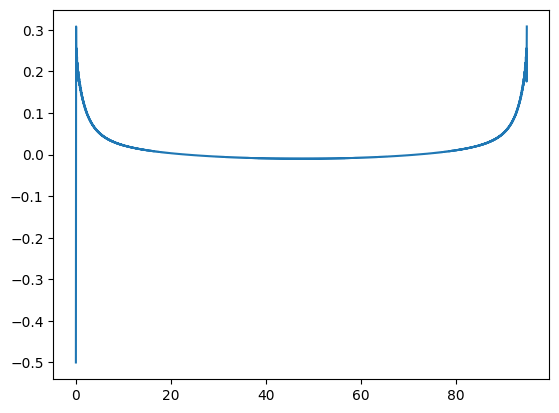

Convergence has been reached, iteration 12
501 data points on real axis
200 data points on imaginary axis
51 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 11.00,	chi2 = 2.729e+09+0.000e+00j,   S = -7.295e-05+0.000e+00j,   nfev = 12,   norm = 1.005+0.000j
log10(alpha) = 10.00,	chi2 = 2.409e+09+0.000e+00j,   S = -9.273e-03+0.000e+00j,   nfev = 18,   norm = 1.055+0.000j
log10(alpha) = 9.00,	chi2 = 5.390e+08+0.000e+00j,   S = -3.809e-01+0.000e+00j,   nfev = 19,   norm = 1.415+0.000j
log10(alpha) = 8.00,	chi2 = 3.446e+07+0.000e+00j,   S = -9.545e-01+0.000e+00j,   nfev = 27,   norm = 1.612+0.000j
log10(alpha) = 7.00,	chi2 = 3.779e+06+0.000e+00j,   S = -1.360e+00+0.000e+00j,   nfev = 35,   norm = 1.355+0.000j
log10(alpha) = 6.00,	chi2 = 2.651e+05+0.000e+00j,   S = -1.795e+00+0.000e+00j,   nfev = 36,   norm = 1.133+0.000j
log10(alpha) = 5.00,	chi2 = 3.713e+04+0.000e+00j,   S = -2.056e+00+0.000e+00j,   nfev = 23,   norm = 1.035+0.000j
log10(alpha) = 4.00,	

e:\jorge\Documents\Universidad\Máster\M2\Electronic Structure\Project\Continuation\solvers.py:355: RuntimeWarning: overflow encountered in exp
  w = np.exp(v)
e:\jorge\Documents\Universidad\Máster\M2\Electronic Structure\Project\Continuation\solvers.py:410: RuntimeWarning: overflow encountered in exp
  return self.model * np.exp(np.dot(self.V_svd, u))
e:\jorge\Documents\Universidad\Máster\M2\Electronic Structure\Project\Continuation\solvers.py:410: RuntimeWarning: invalid value encountered in multiply
  return self.model * np.exp(np.dot(self.V_svd, u))
e:\jorge\Documents\Universidad\Máster\M2\Electronic Structure\Project\Continuation\solvers.py:471: RuntimeWarning: invalid value encountered in multiply
  self.E * (self.im_data - np.trapz(self.kernel.real_matrix() * A[None, :], self.re_axis, axis=-1)) ** 2)
c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4979: RuntimeWarning: invalid value encountered in multiply
  ret = (d * (y[tuple(

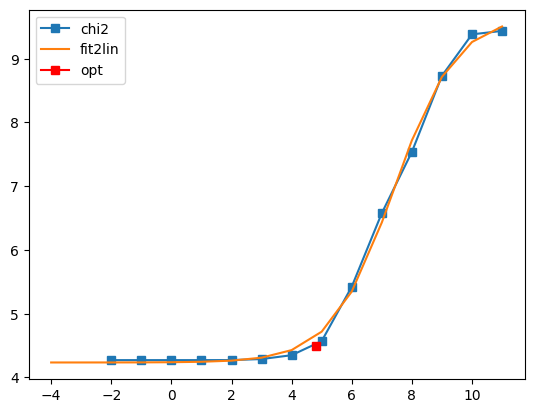

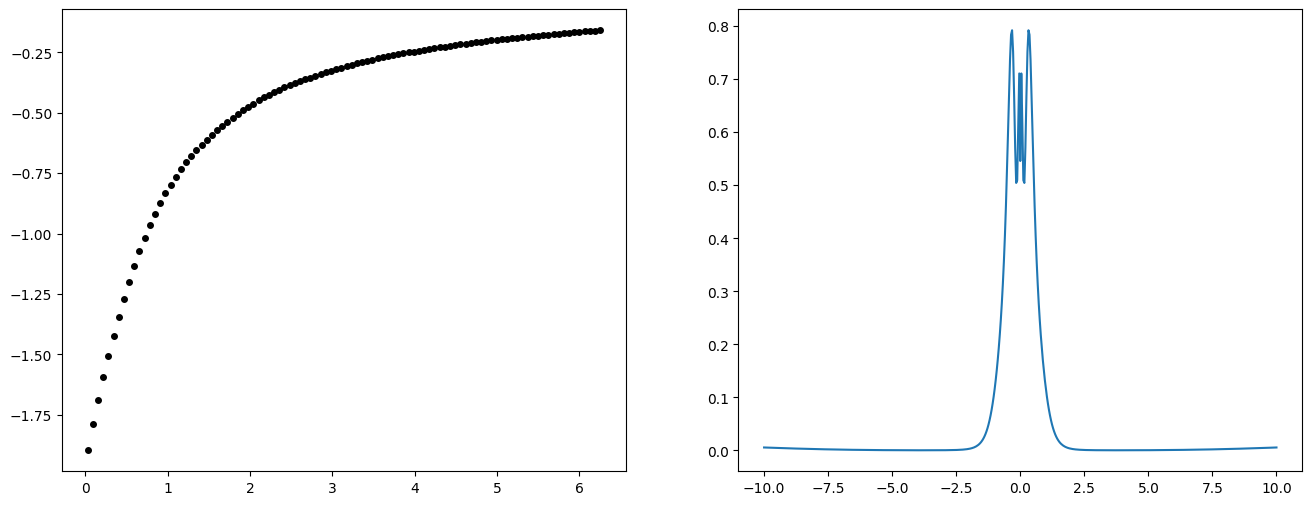

In [122]:
########################################################################
# DMFT LOOP
########################################################################

G_loc, g_0, g_0_tau, new_S_imp = DMFT_first_iteration(u0, S_imp, energies, DOS, Momega, tau, beta)
G_imp = solve_dyson(g_0, new_S_imp)
S_imp = new_S_imp

for k_loop in range(nloop):

    G_loc, g_0, g_0_tau, new_S_imp = DMFT_iteration_first_half(u0, S_imp, energies, DOS, Momega, tau, beta)
    G_imp = solve_dyson(g_0, new_S_imp)
    
    if convergence_test(G_imp, G_loc, tol):
        print('Convergence has been reached, iteration '+str(k_loop))
        break
    else:
        S_imp = xmix * new_S_imp + (1-xmix) * S_imp

path1 = '.\\g_loc.dat'
with open(path1, 'w') as writer:

    for i in range(len(Momega)):
        writer.write(str(Momega[i]) + ' ' + str(np.real(G_loc[i])) + ' ' + str(np.imag(G_loc[i])) +'\n')

path2 = '.\\sigma.dat'
with open(path2, 'w') as writer:

    for i in range(len(Momega)):
        writer.write(str(Momega[i]) + ' ' + str(np.real(S_imp[i])) + ' ' + str(np.imag(S_imp[i])) +'\n')


#import pade as pade
#pade

#G_loc_real_table = np.loadtxt('.\\pade.dat')
#G_loc_real = G_loc_real_table[:,1] + 1.0j*G_loc_real_table[:,2]

Romega = np.linspace(-10, 10, 501, endpoint = True)
G_loc_real = real_axis_gf(G_loc, 100, Romega, beta)

#spectral = compute_spectral(G_loc_real)
#Romega = G_loc_real_table[:,0]


fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(Momega[0:100], G_loc.imag[0:100], 'ko', ms = 4)
ax[1].plot(Romega, G_loc_real)
plt.show()